In [5]:
!pip install pandas
!pip install dowhy
!pip install pgmpy
!pip install pygraphviz
!pip install numpy
!pip install graphviz
!pip install numpy
!pip install networkx
!pip install causal-learn

In [18]:
import pandas as pd
import os
path = os.getcwd()+"/local/uni/inference/Task4/"

file_path = path + './cancer_patient_data_sets.csv'
df = pd.read_csv(file_path, header=0, sep=';')

#remove the first two columns from the dataframe
df = df.drop(columns=['index', 'Patient Id'])

# map function that replaces Low = 0, Medium = 1, High = 1
def replace_values(value):
    switch = {
        "Low": 0,
        "Medium": 1,
        "High": 2
    }
    return switch.get(value, "Invalid")

# apply the function to Level columns in the dataframe
df['Level'] = df['Level'].apply(replace_values)
# select specific columns for further process
reducedDf = df[['Level', 'Genetic Risk', 'Smoking', 'Alcohol use', 'Obesity', 'Gender']]
# rename dataframe column from Level to Cancer Risk
reducedDf = reducedDf.rename(columns={'Level': 'Cancer Risk'})


[[0 3 3 4 4 1]
 [1 4 2 1 2 1]
 [2 5 2 5 7 1]
 ...
 [2 5 2 5 7 2]
 [2 7 8 8 7 2]
 [2 5 2 5 7 1]]


  0%|          | 0/6 [00:00<?, ?it/s]

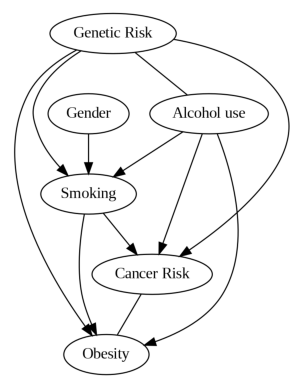

In [16]:
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.cit import kci
labels = [f'{col}' for i, col in enumerate(reducedDf.columns)]
data = reducedDf.to_numpy()

print(data)

cg = pc(data, 0.01, kci, kernelZ='Polynomial', approx=False, est_width='median')
from causallearn.utils.GraphUtils import GraphUtils
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import io

pyd = GraphUtils.to_pydot(cg.G, labels=labels)
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
# save image 
plt.imsave("cg.png", img)
plt.axis('off')
plt.imshow(img)
plt.show()

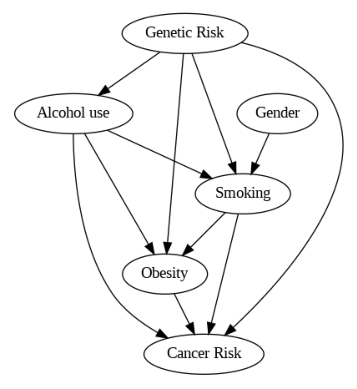

In [4]:
# Manually created Graph to create DAG from data learned structure
from pgmpy.models import BayesianNetwork

import matplotlib.pyplot as plt

model = BayesianNetwork([('Gender', 'Smoking'), 
                         ('Smoking', 'Obesity'), 
                         ('Alcohol use', 'Smoking'), 
                         ('Genetic Risk', 'Smoking'), 
                         ('Smoking', 'Cancer Risk'), 
                         ('Alcohol use', 'Cancer Risk'), 
                         ('Genetic Risk', 'Cancer Risk'),
                         ('Alcohol use','Obesity'),
                         ('Genetic Risk','Obesity'),
                         ('Obesity','Cancer Risk'),
                         ('Genetic Risk','Alcohol use'),])
viz = model.to_graphviz()

viz.draw(path + "./domain_knowledge_graph.png", prog="dot")
#show image from path in plt
img = plt.imread(path + "./domain_knowledge_graph.png")
plt.imshow(img)
plt.axis('off')
plt.show()

In [82]:
def getCausalEffect(maxAlcUse, maxGeneticRisk, filteredDf):
    print("Max Alcohole Use Indicator: ", maxAlcUse)
    print("Max Genetic Risk Indicator: ", maxGeneticRisk)
    print(filteredDf.head(5))
    numberOfEntriesWithCancerRiskAndSmokingLvl = filteredDf['Cancer Risk'].count()
    numberOfTotalEntries = reducedDf['Cancer Risk'].count()
    
    if(numberOfEntriesWithCancerRiskAndSmokingLvl == 0):
        print("no data")
        return
    sum = 0
    for alcUse in range(maxAlcUse+1):
        for genRisk in range(maxGeneticRisk+1):
            # calculate p(CR = cancerRisk | S=smokingLevel, A=alcUse, GR=genRisk)
            alcGenFiltered = filteredDf.loc[(filteredDf['Alcohol use'] == alcUse) & (filteredDf['Genetic Risk'] == genRisk)]
            estimateCondProp = alcGenFiltered['Cancer Risk'].count()/numberOfEntriesWithCancerRiskAndSmokingLvl
            # calculate P(A=alcUse, GR=genRisk)
            alcGenWholeDataset= reducedDf.loc[(reducedDf['Alcohol use'] == alcUse) & (reducedDf['Genetic Risk'] == genRisk)]
            jointProp = alcGenWholeDataset['Cancer Risk'].count() / numberOfTotalEntries
            sum += estimateCondProp*jointProp
    return sum

def getCausalEffectOfSmokingOnCancerRisk(cancerRisk, smokingLevel):
    maxAlcUse = reducedDf['Alcohol use'].max()
    maxGeneticRisk = reducedDf['Genetic Risk'].max()
    
    filteredDf = reducedDf.loc[(reducedDf['Cancer Risk'] == cancerRisk) & (reducedDf['Smoking'] == smokingLevel)]
    effect = getCausalEffect(maxAlcUse, maxGeneticRisk, filteredDf)*100 # convert to percent
    
    print("The causal effect when smoking at lvl", smokingLevel, "to have a cancer risk of", cancerRisk, "is", effect, "%")
    
getCausalEffectOfSmokingOnCancerRisk(2, 8)

Max Alcohole Use Indicator:  8
Max Genetic Risk Indicator:  7
    Cancer Risk  Genetic Risk  Smoking  Alcohol use  Obesity  Gender
4             2             7        8            8        7       1
20            2             6        8            8        3       1
22            2             7        8            8        7       1
46            2             6        8            8        3       1
68            2             7        8            8        7       1
The causal effect when smoking at lvl 8 to have a cancer risk of 2 is 13.292405063291143 %


In [85]:

maxAlcUse = reducedDf['Alcohol use'].max()
maxGeneticRisk = reducedDf['Genetic Risk'].max()
 
filteredDf = reducedDf.loc[(reducedDf['Cancer Risk'] != 0) & (reducedDf['Smoking'] != 0)]
effect = getCausalEffect(maxAlcUse, maxGeneticRisk, filteredDf)*100 # convert to percent

print("The causal effect when smoking at all to have a hightend cancer risk is", effect, "%")
    

Max Alcohole Use Indicator:  8
Max Genetic Risk Indicator:  7
   Cancer Risk  Genetic Risk  Smoking  Alcohol use  Obesity  Gender
1            1             4        2            1        2       1
2            2             5        2            5        7       1
3            2             6        7            7        7       1
4            2             7        8            8        7       1
5            2             5        2            5        7       1
The causal effect when smoking at all to have a hightend cancer risk is 9.5493543758967 %
